In [29]:
import numpy as np
import pandas as pd
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

## Import Data

In [13]:
data, labels = shap.datasets.adult(display=True)

In [15]:
labels = np.array([int(label) for label in labels])

In [17]:
print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


In [19]:
Counter(labels)

Counter({0: 24720, 1: 7841})

## Feature Engineering:
### Turning categories into integers to be fed into machine learning model

In [27]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null int8
Education-Num     32561 non-null float32
Marital Status    32561 non-null int8
Occupation        32561 non-null int8
Relationship      32561 non-null int8
Race              32561 non-null int8
Sex               32561 non-null int8
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null int8
dtypes: float32(5), int8(7)
memory usage: 858.6 KB


## Train / Test Split

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_train.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,6,9.0,2,5,5,4,0,0.0,2179.0,12.0,39
1216,48.0,6,10.0,2,3,0,0,1,7688.0,0.0,40.0,39
27962,23.0,7,10.0,2,10,0,4,1,0.0,0.0,30.0,39


## Maintaining category values for later interpretation

In [31]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,Self-emp-not-inc,9.0,Married-civ-spouse,Farming-fishing,Wife,White,Female,0.0,2179.0,12.0,United-States
1216,48.0,Self-emp-not-inc,10.0,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688.0,0.0,40.0,United-States
27962,23.0,State-gov,10.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States


## Initializing and training model

In [32]:
%%time
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 16.1 s, sys: 120 ms, total: 16.2 s
Wall time: 16.4 s


In [33]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

## Model Testing

In [37]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.90      0.94      0.92      7455
          1       0.76      0.67      0.71      2314

avg / total       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6972   483
        1        775  1539


## Feature Importance using xgb importance

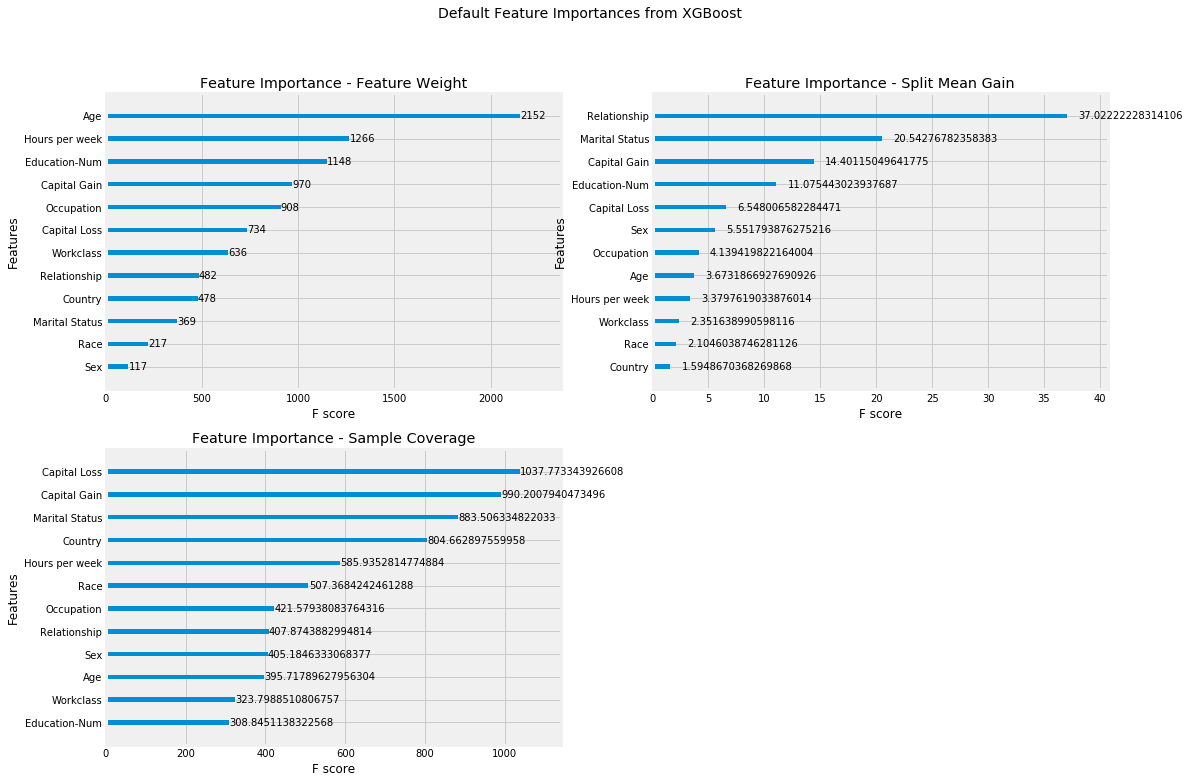

In [40]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

## ELI5 Feature Importance

### Overall Feature Importance

In [41]:
eli5.show_weights(xgc.get_booster())

Weight,Feature
0.3294,Relationship
0.1828,Marital Status
0.1281,Capital Gain
0.0985,Education-Num
0.0583,Capital Loss
0.0494,Sex
0.0368,Occupation
0.0327,Age
0.0301,Hours per week
0.0209,Workclass


### Individual Prediction Explanation using Feature Importance

#### Under $50k

In [43]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns),
                     show_feature_values=True)

Actual Label: 0
Predicted Label: 0


#### Over $50k

In [44]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns), 
                     show_feature_values=True)

Actual Label: 1
Predicted Label: 1


## Skater Feature Importance

In [46]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [53]:
interpreter = Interpretation(training_data=X_test, 
                             feature_names=list(data.columns))

In [48]:
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, 
                         target_names=['$50K or less', 'More than $50K'])

[12/12] features ████████████████████ Time elapsed: 3 seconds

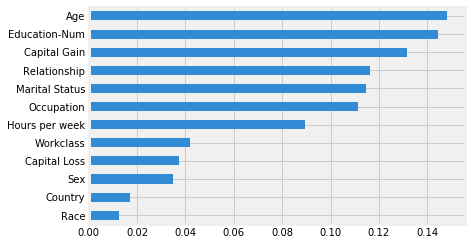

In [58]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=False)

## Skater Partial Dependence Plots

[44/44] grid cells ████████████████████ Time elapsed: 15 seconds

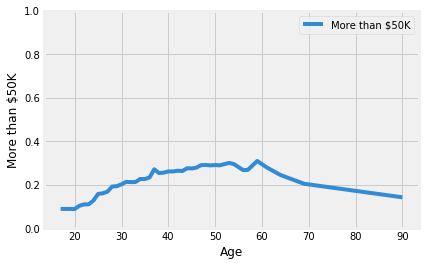

In [60]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=False, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

[16/16] grid cells ████████████████████ Time elapsed: 6 seconds

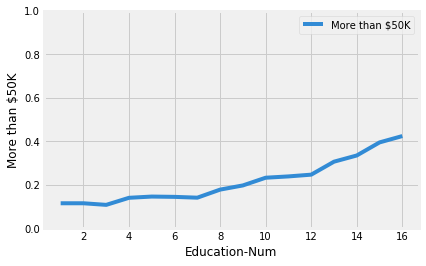

In [61]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=False, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

[6/6] grid cells ████████████████████ Time elapsed: 2 seconds

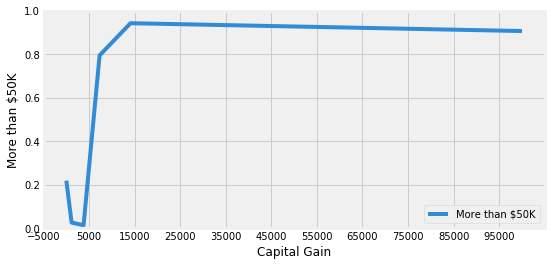

In [62]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=False, figsize = (8, 4), n_samples=23000)
yl = r[0][1].set_ylim(0, 1) 
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

In [63]:
pd.concat([data_disp[['Relationship']], data[['Relationship']]], 
          axis=1).drop_duplicates()

,Relationship,Relationship
0,Not-in-family,1
1,Husband,0
4,Wife,5
12,Own-child,3
17,Unmarried,4
74,Other-relative,2


[6/6] grid cells ████████████████████ Time elapsed: 2 seconds

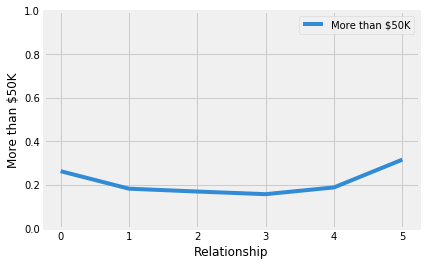

In [65]:
r = interpreter.partial_dependence.plot_partial_dependence(['Relationship'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=False, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

## Skater Two-Way Partial Dependence Plots

[1136/1136] grid cells ████████████████████ Time elapsed: 389 seconds

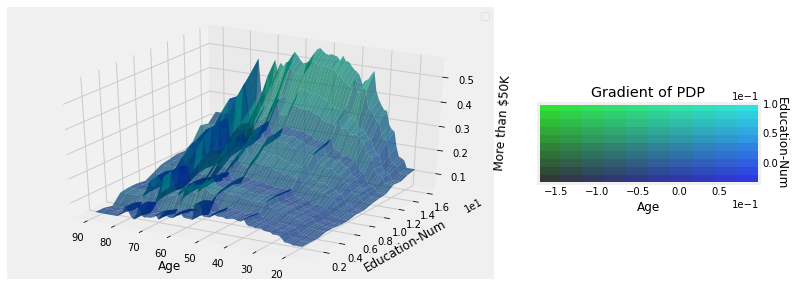

In [66]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)